# Quantium Virtual Internship - Retail Strategy and Analytics

##Solution for Data preparation and customer analytics

This file outlines a sample response to the data insights and strategy task using Python.

## Load required libraries and datasets

In [7]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optionally for advanced visualizations
import re  # For regex filtering


In [8]:
# Load datasets using pandas
transaction_data = pd.read_excel("/content/QVI_transaction_data.xlsx")
customer_data = pd.read_csv("/content/QVI_purchase_behaviour.csv")


## Exploratory data analysis

The first step in any analysis is to first understand the data. Let’s take a look at each of the datasets provided.

### Examining transaction data

We can use info() to look at the format of each column and see a sample of the data. As we have read in the dataset as a data.table , we can also run transactionData in the console to see a sample of the data or use head() to look at the first 5 rows.


Let’s check if columns we would expect to be numeric are in numeric form and date columns are in date format

In [9]:
# Check the structure of the transaction data
transaction_data.info()

# View the first few rows of the dataset
transaction_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


We can see that the date column is in an integer format. Let’s change this to a date format.

In [10]:
# Convert the DATE column from an integer to a date format (Excel format starts from 1899-12-30)
transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'], origin='1899-12-30', unit='D')

# Check the updated DATE column
transaction_data.head()


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


We should check that we are looking at the right products by examining PROD_NAME.

In [11]:
# Check unique product names
transaction_data['PROD_NAME'].value_counts()


,count
PROD_NAME,
Kettle Mozzarella Basil & Pesto 175g,3304
Kettle Tortilla ChpsHny&Jlpno Chili 150g,3296
Cobs Popd Swt/Chlli &Sr/Cream Chips 110g,3269
Tyrrells Crisps Ched & Chives 165g,3268
Cobs Popd Sea Salt Chips 110g,3265
...,...
RRD Pc Sea Salt 165g,1431
Woolworths Medium Salsa 300g,1430
NCC Sour Cream & Garden Chives 175g,1419


Looks like we are definitely looking at potato chips but how can we check that these are all chips? We can do some basic text analysis by summarising the individual words in the product name.

In [12]:
# Split product names into individual words and create a list
product_words = pd.Series(' '.join(transaction_data['PROD_NAME']).split()).value_counts()

# View the most common words
product_words.head()


,count
175g,60561
Chips,49770
150g,41633
Kettle,41288
&,35565


As we are only interested in words that will tell us if the product is chips or not, let’s remove all words with digits and special characters such as ‘&’ from our set of product words.

In [13]:
# Filter out words containing digits and special characters
product_words_filtered = product_words[~product_words.index.str.contains(r'\d|[^a-zA-Z]')]

# View the filtered word counts
product_words_filtered.head()


,count
Chips,49770
Kettle,41288
Smiths,28860
Salt,27976
Cheese,27890


There are salsa products in the dataset but we are only interested in the chips category, so let’s remove these.

In [14]:
# Remove salsa products by filtering out rows with 'salsa' in PROD_NAME
transaction_data = transaction_data[~transaction_data['PROD_NAME'].str.contains('salsa', case=False)]


Next, we can use describe() to check summary statistics such as mean, min and max values for each feature to see if there are any obvious outliers in the data and if there are any nulls in any of the columns using isnull() (NA's : number of nulls will appear in the output if there are any nulls).

In [15]:
# Summary statistics
transaction_data.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,2018-12-30 01:19:01.211467520,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000
std,NaN,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828


In [16]:
# Check for missing values (nulls)
transaction_data.isnull().sum()


,0
DATE,0
STORE_NBR,0
LYLTY_CARD_NBR,0
TXN_ID,0
PROD_NBR,0
PROD_NAME,0
PROD_QTY,0
TOT_SALES,0


There are no nulls in the columns but product quantity appears to have an outlier which we should investigate further. Let’s investigate further the case where 200 packets of chips are bought in one transaction.

In [17]:
# Check for outliers in the PROD_QTY column (specifically for large values like 200)
outlier_data = transaction_data[transaction_data['PROD_QTY'] == 200]




There are two transactions where 200 packets of chips are bought in one transaction and both of these transactions where by the same customer.

In [18]:
#Let's see if the customer has had other transactions
# Investigate the specific customer (LYLTY_CARD_NBR 226000)
outlier_transactions = transaction_data[transaction_data['LYLTY_CARD_NBR'] == 226000]



It looks like this customer has only had the two transactions over the year and is not an ordinary retail customer. The customer might be buying chips for commercial purposes instead. We’ll remove this loyalty card number from further analysis.

In [19]:
# Remove this customer from further analysis
transaction_data = transaction_data[transaction_data['LYLTY_CARD_NBR'] != 226000]

In [20]:
# Check the summary statistics after filtering
transaction_data.describe()


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246740,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000,246740.000000
mean,2018-12-30 01:18:58.448569344,135.050361,1.355303e+05,1.351304e+05,56.352213,1.906456,7.316113
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756875e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351815e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030832e+05,2.026522e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000
std,NaN,76.786971,8.071520e+04,7.814760e+04,33.695235,0.342499,2.474897


That’s better. Now, let’s look at the number of transaction lines over time to see if there are any obvious data issues such as missing data.

In [21]:
# Create a DataFrame with all dates between the min and max transaction dates
all_dates = pd.DataFrame(pd.date_range(start=transaction_data['DATE'].min(),
                                       end=transaction_data['DATE'].max()), columns=['DATE'])




In [22]:
# Count the number of transactions per day
transactions_per_day = transaction_data.groupby('DATE').size().reset_index(name='count')



In [23]:
# Merge all_dates with transactions_per_day
transactions_by_day = pd.merge(all_dates, transactions_per_day, on='DATE', how='left').fillna(0)

<ipython-input-24-f76db1cb418d>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


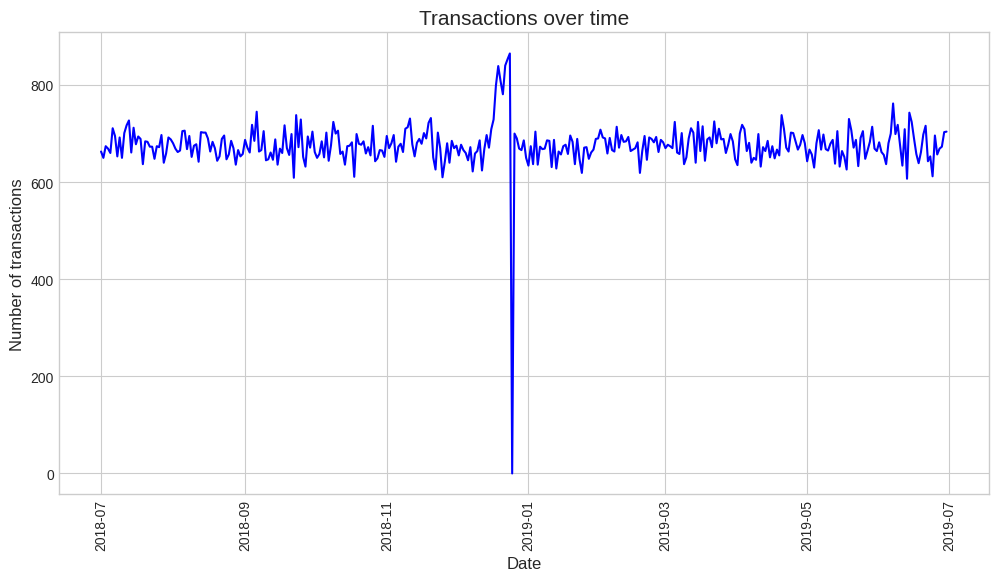

In [24]:
# Set the plot style
plt.style.use('seaborn-whitegrid')

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(transactions_by_day['DATE'], transactions_by_day['count'], marker='', color='b')
plt.title('Transactions over time', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of transactions', fontsize=12)
plt.xticks(rotation=90)
plt.show()


We can see that there is an increase in purchases in December and a break in late December. Let’s zoom in on this

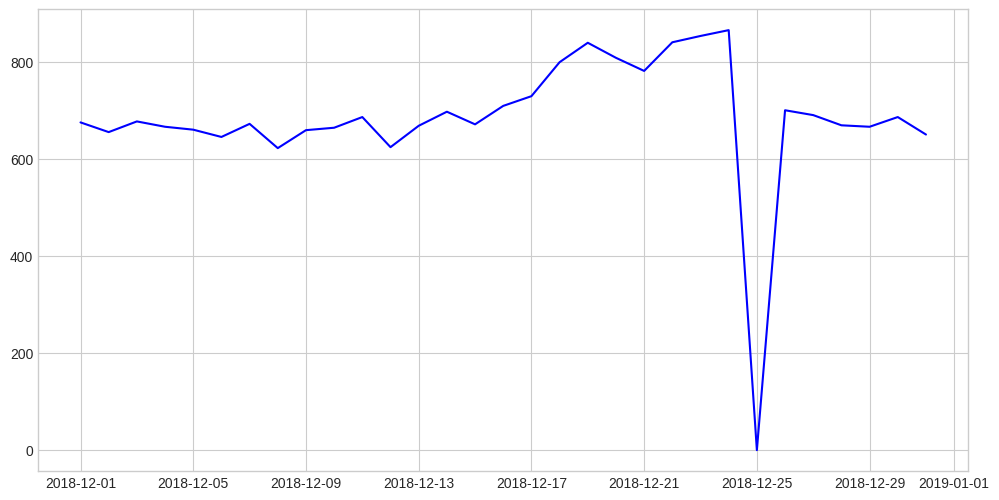

In [27]:
#Filter to December and look at individual days and plot a line graph
december_data = transactions_by_day[transactions_by_day['DATE'].dt.month == 12]
plt.figure(figsize=(12, 6))
plt.plot(december_data['DATE'], december_data['count'], marker='', color='b')


We can see that the increase in sales occurs in the lead-up to Christmas and that there are zero sales on Christmas day itself. This is due to shops being closed on Christmas day.

Now that we are satisfied that the data no longer has outliers, we can move on to creating other features such as brand of chips or pack size from PROD_NAME. We will start with pack size.

In [53]:
#Pack size
#We can work this out by taking the digits that are in PROD_NAME
# Extract the pack size by looking for numbers followed by 'g' (grams) in the PROD_NAME
# Extract the pack size by looking for numbers followed by 'g' (grams) in the PROD_NAME
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract(r'(\d+)(?=g)').astype(int)

# Order the DataFrame by PACK_SIZE
ordered_transaction_data = transaction_data.sort_values(by='PACK_SIZE', ascending=True)

# Check the complete rows to ensure pack sizes are ordered correctly
display(ordered_transaction_data)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
197073,2019-01-04,168,168107,170001,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70
91895,2019-03-16,160,160189,161318,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70
238226,2018-08-17,180,180038,181198,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70
142815,2018-12-31,129,129063,132578,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70
184377,2018-12-04,259,259089,257994,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70
...,...,...,...,...,...,...,...,...,...
93519,2019-06-07,183,183026,184926,14,Smiths Crnkle Chip Orgnl Big Bag 380g,2,11.8,380
93514,2019-06-28,183,183024,184915,14,Smiths Crnkle Chip Orgnl Big Bag 380g,2,11.8,380
13910,2018-07-25,201,201162,200629,14,Smiths Crnkle Chip Orgnl Big Bag 380g,2,11.8,380
214333,2018-12-24,217,217332,217772,4,Dorito Corn Chp Supreme 380g,2,13.0,380


The largest size is 380g and the smallest size is 70g - seems sensible!

If there are any product names without a pack size or with an incorrect format, they will be assigned a NaN value. We can investigate those values if needed:

In [48]:
# Check for any missing pack sizes
missing_pack_size = transaction_data[transaction_data['PACK_SIZE'].isnull()]

# Display the rows with missing pack sizes
missing_pack_size[['PROD_NAME', 'PACK_SIZE']].head()


,PROD_NAME,PACK_SIZE


if there were missing values

In [49]:
#Remove the missing values
transaction_data = transaction_data.dropna(subset=['PACK_SIZE'])

In [54]:
# Summary statistics for the pack size
transaction_data['PACK_SIZE'].describe()

,PACK_SIZE
count,240676.000000
mean,175.302286
std,60.014468
min,70.000000
25%,150.000000
50%,170.000000
75%,175.000000
max,380.000000


Now, we can proceed to explore the pack sizes

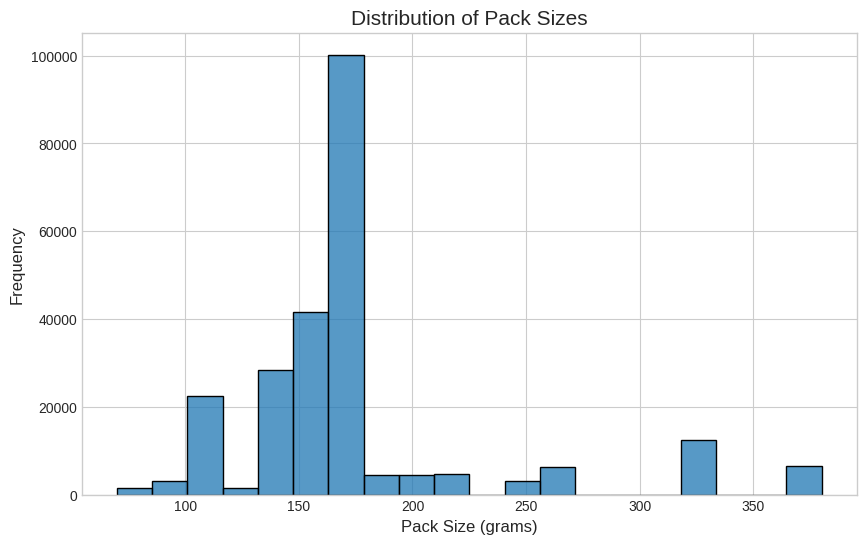

In [55]:
# Plot the distribution of pack sizes
plt.figure(figsize=(10, 6))
sns.histplot(transaction_data['PACK_SIZE'], bins=20, kde=False)
plt.title('Distribution of Pack Sizes', fontsize=15)
plt.xlabel('Pack Size (grams)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

Pack sizes created look reasonable and now to create brands, we can use the first word in PROD_NAME to work out the brand name

In [56]:
#### Brands
# Extract the brand name from the product name
transaction_data['BRAND'] = transaction_data['PROD_NAME'].str.split().str[0]

#### Checking brands
# Check the unique brands
transaction_data['BRAND'].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

Some of the brand names look like they are of the same brands - such as RED and RRD, which are both Red Rock Deli chips. Let’s combine these together.

In [57]:
#### Clean brand names
# Replace 'RRD' with 'RED' in the 'BRAND' column
transaction_data['BRAND'] = transaction_data['BRAND'].replace('RRD', 'RED')

# Check the updated unique brands
transaction_data['BRAND'].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RED', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

### Examining customer data

Now that we are happy with the transaction dataset, let’s have a look at the customer dataset.

In [58]:
#### Examining customer data
# Check the structure of the customer data
customer_data.info()

# View the first few rows of the dataset
customer_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


Let’s have a closer look at the LIFESTAGE and PREMIUM_CUSTOMER columns.

In [60]:
#### Examining the values of lifestage and premium_customer
# Check the unique values in the LIFESTAGE column
customer_data['LIFESTAGE'].unique()



array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

In [61]:
# Check the unique values in the PREMIUM_CUSTOMER column
customer_data['PREMIUM_CUSTOMER'].unique()

array(['Premium', 'Mainstream', 'Budget'], dtype=object)

As there do not seem to be any issues with the customer data, we can now go ahead and join the transaction and customer data sets together

In [62]:
#### Merge transaction data to customer data
# Merge the transaction and customer data sets
merged_data = pd.merge(transaction_data, customer_data, on='LYLTY_CARD_NBR', how='left')

# Check the merged data
merged_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget


As the number of rows in data is the same as that of transactionData, we can be sure that no duplicates were created. This is because we created data by setting a left join which means take all the rows in transactionData and find rows with matching values in shared columns and then joining the details in these rows to the x or the first mentioned table.

Let’s also check if some customers were not matched on by checking for nulls.

In [63]:
#check for null
merged_data.isnull().sum()

,0
DATE,0
STORE_NBR,0
LYLTY_CARD_NBR,0
TXN_ID,0
PROD_NBR,0
PROD_NAME,0
PROD_QTY,0
TOT_SALES,0
PACK_SIZE,0
BRAND,0


Great, there are no nulls! So all our customers in the transaction data has been accounted for in the customer dataset

Data exploration is now complete!

## Data analysis on customer segments

Now that the data is ready for analysis, we can define some metrics of interest to the client:



• Who spends the most on chips (total sales), describing customers by lifestage and how premium their general purchasing behaviour is

• How many customers are in each segment

• How many chips are bought per customer by segment

• What’s the average chip price by customer segment


We could also ask our data team for more information. Examples are:



• The customer’s total spend over the period and total spend for each transaction to understand what proportion of their grocery spend is on chips

• Proportion of customers in each customer segment overall to compare against the mix of customers who purchase chips



Let’s start with calculating total sales by LIFESTAGE and PREMIUM_CUSTOMER and plotting the split by these segments to describe which customer segment contribute most to chip sales

<function matplotlib.pyplot.show(close=None, block=None)>

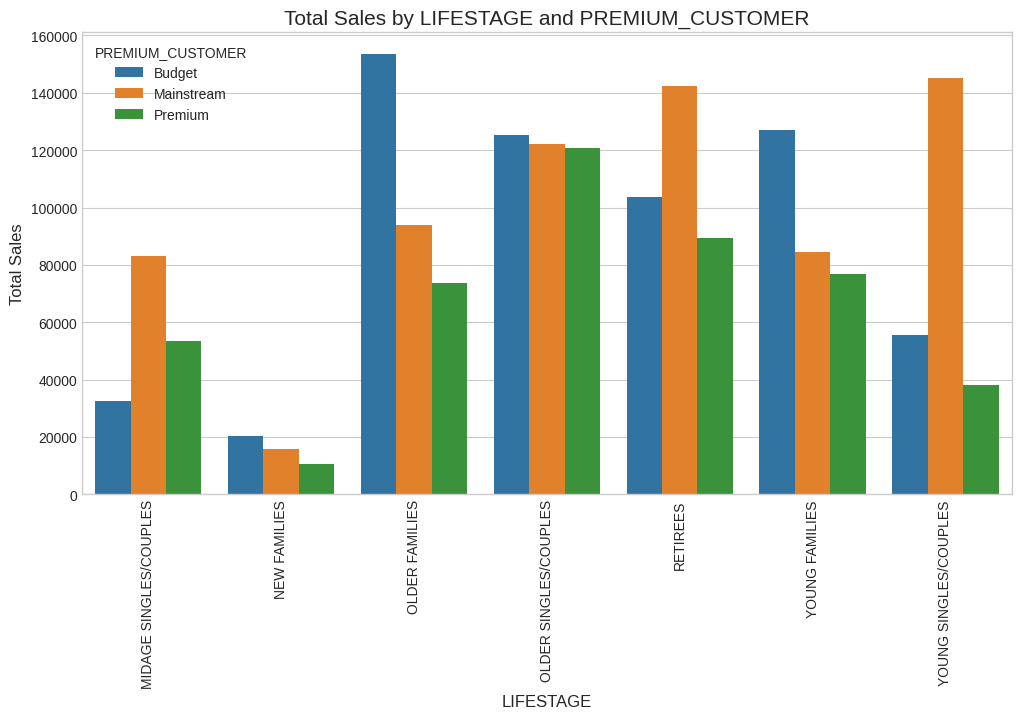

In [65]:
#### Total sales by LIFESTAGE and PREMIUM_CUSTOMER
# Calculate total sales by LIFESTAGE and PREMIUM_CUSTOMER
total_sales_by_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

#### Create plot
# Create a bar plot of total sales by LIFESTAGE and PREMIUM_CUSTOMER
plt.figure(figsize=(12, 6))
sns.barplot(x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER', data=total_sales_by_segment)
plt.title('Total Sales by LIFESTAGE and PREMIUM_CUSTOMER', fontsize=15)
plt.xlabel('LIFESTAGE', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=90)
plt.show

Sales are coming mainly from Budget - older families, Mainstream - young singles/couples, and Mainstream - retirees

Let’s see if the higher sales are due to there being more customers who buy chips.

In [68]:
#### Number of customers by LIFESTAGE and PREMIUM_CUSTOMER
# Calculate the number of customers by LIFESTAGE and PREMIUM_CUSTOMER
num_customers_by_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).size().reset_index() # Use reset_index() to convert the result to a DataFrame
num_customers_by_segment.columns = ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'NUM_CUSTOMERS']

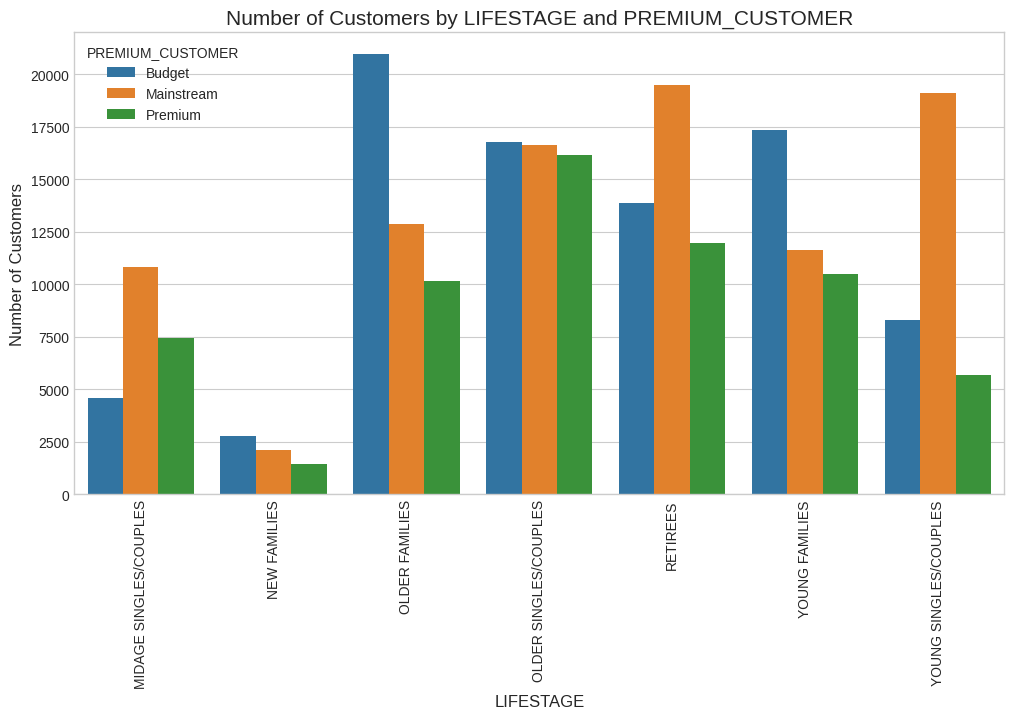

In [70]:
#### Create plot
# Create a bar plot of number of customers by LIFESTAGE and PREMIUM_CUSTOMER
plt.figure(figsize=(12, 6))
sns.barplot(x='LIFESTAGE', y='NUM_CUSTOMERS', hue='PREMIUM_CUSTOMER', data=num_customers_by_segment)
plt.title('Number of Customers by LIFESTAGE and PREMIUM_CUSTOMER', fontsize=15)
plt.xlabel('LIFESTAGE', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=90)
plt.show()

There are more Mainstream - young singles/couples and Mainstream - retirees who buy chips. This con- tributes to there being more sales to these customer segments but this is not a major driver for the Budget - Older families segment.

Higher sales may also be driven by more units of chips being bought per customer. Let’s have a look at this next.

In [71]:
#### Average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER
# Calculate the average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER
avg_units_per_customer_by_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].mean().reset_index()
avg_units_per_customer_by_segment.columns = ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'AVG_UNITS_PER_CUSTOMER']

<function matplotlib.pyplot.show(close=None, block=None)>

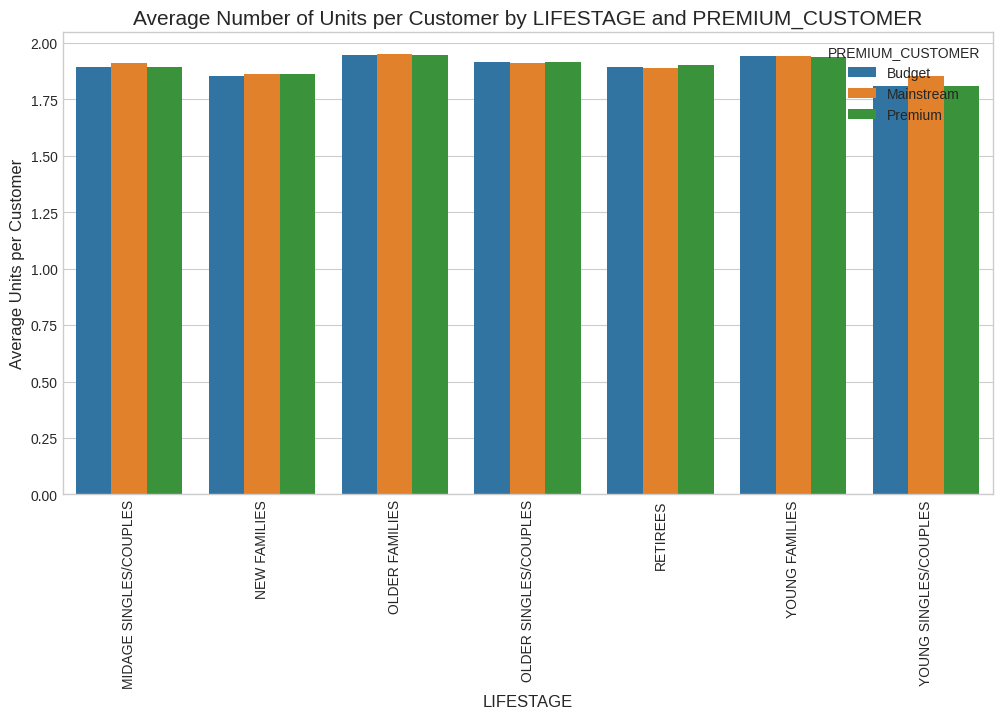

In [73]:
#### Create plot
# Create a bar plot of average number of units per customer by LIFESTAGE and PREMIUM_CUSTOMER
plt.figure(figsize=(12, 6))
sns.barplot(x='LIFESTAGE', y='AVG_UNITS_PER_CUSTOMER', hue='PREMIUM_CUSTOMER', data=avg_units_per_customer_by_segment)
plt.title('Average Number of Units per Customer by LIFESTAGE and PREMIUM_CUSTOMER', fontsize=15)
plt.xlabel('LIFESTAGE', fontsize=12)
plt.ylabel('Average Units per Customer', fontsize=12)
plt.xticks(rotation=90)
plt.show

Older families and young families in general buy more chips per customer

Let’s also investigate the average price per unit chips bought for each customer segment as this is also a driver of total sales.

In [78]:
#### Average price per unit by LIFESTAGE and PREMIUM_CUSTOMER
# Calculate the average price per unit by LIFESTAGE and PREMIUM_CUSTOMER
# Check if 'UNIT_PRICE' is in the columns
print(merged_data.columns)


Index(['DATE', 'STORE_NBR', 'LYLTY_CARD_NBR', 'TXN_ID', 'PROD_NBR',
       'PROD_NAME', 'PROD_QTY', 'TOT_SALES', 'PACK_SIZE', 'BRAND', 'LIFESTAGE',
       'PREMIUM_CUSTOMER'],
      dtype='object')


In [85]:
#Calculate the average price per unit by LIFESTAGE and PREMIUM_CUSTOMER create a temporory column for Unit price
merged_data['UNIT_PRICE'] = merged_data['TOT_SALES'] / merged_data['PROD_QTY']

avg_price_per_unit_by_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['UNIT_PRICE'].mean().reset_index()
avg_price_per_unit_by_segment.columns = ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'AVG_PRICE_PER_UNIT']

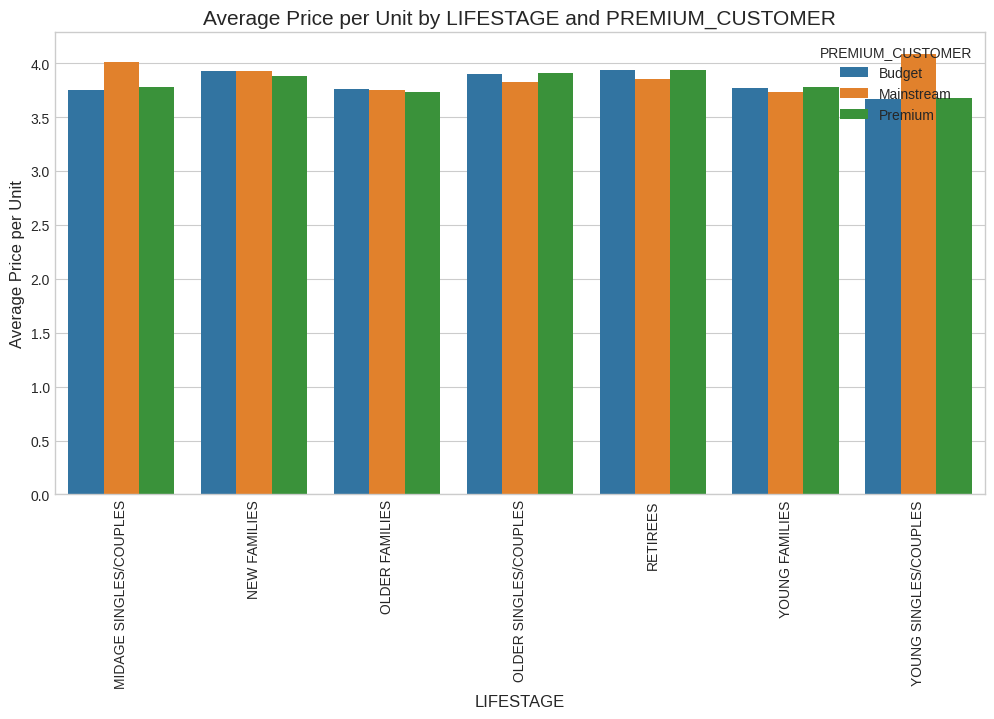

In [88]:
# Create a bar plot of average price per unit by LIFESTAGE and PREMIUM_CUSTOMER
plt.figure(figsize=(12, 6))
sns.barplot(x='LIFESTAGE', y='AVG_PRICE_PER_UNIT', hue='PREMIUM_CUSTOMER', data=avg_price_per_unit_by_segment)
plt.title('Average Price per Unit by LIFESTAGE and PREMIUM_CUSTOMER', fontsize=15)
plt.xlabel('LIFESTAGE', fontsize=12)
plt.ylabel('Average Price per Unit', fontsize=12)
plt.xticks(rotation=90)
plt.show()


Mainstream midage and young singles and couples are more willing to pay more per packet of chips com- pared to their budget and premium counterparts. This may be due to premium shoppers being more likely to buy healthy snacks and when they buy chips, this is mainly for entertainment purposes rather than their own consumption. This is also supported by there being fewer premium midage and young singles and couples buying chips compared to their mainstream counterparts.

As the difference in average price per unit isn’t large, we can check if this difference is statistically different.